# How good are language models we use for Style Transfer?

Let's load pretrained language models on sentiment data. We will test both yelp and sentiment treebank language models. 

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from tqdm.auto import tqdm

plt.style.use('fivethirtyeight')

In [3]:
from style_transfer import Tokenizer, get_dataset, translate
sys.path.append('../deep-latent-sequence-model/src')
from lm_lstm import LSTM_LM

device = torch.device('cpu')
model_dir = '../deep-latent-sequence-model/pretrained_lm/sentiment_style0'
model_path = os.path.join(model_dir, 'model.pt')
model = torch.load(model_path).eval().to(device)

vocab_path = 'data/sentiment/text.vocab'
with open(vocab_path) as f:
    vocab = [word.strip() for word in f.readlines()]
tokenizer = Tokenizer(vocab)

In [4]:
model

LSTM_LM(
  (embed): Embedding(11334, 64, padding_idx=0)
  (dropout_in): Dropout(p=0.3, inplace=False)
  (dropout_out): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(64, 256, batch_first=True)
  (pred_linear): Linear(in_features=256, out_features=11334, bias=True)
  (loss): CrossEntropyLoss()
)

## Predicting next word given a sequence of words 

In [5]:
x = torch.tensor([[1, 2, 3]])
x_len = torch.tensor([3])
print(model.log_probability(x, x_len))
logits = model.decode(x, x_len)  # (batch_size, seq_len, vocab_size)
output_logits = logits[0, -1, :]
output_logits.shape

tensor([-27.3450], grad_fn=<NegBackward>)


torch.Size([11334])

In [6]:
predicted_words = output_logits.argmax()
predicted_words

tensor(29, grad_fn=<NotImplemented>)

In [7]:
tokenizer.decode(6904)

'ode'

## Deterministic sequence generation given initial word

In [8]:
tokenizer.tokenize('i')

[5026]

Single next word to see if this works.

In [9]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
x = torch.tensor([tokens])
x_len = [len(tokens)]
next_word_logits = model.decode(x, x_len)[0, -1, :]
predicted_token = next_word_logits.argmax().item()
predicted_token, tokenizer.decode(predicted_token)

(4092, 'food')

Generating sequence of words.

In [10]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
while words[-1] != '.':
    x = torch.tensor([tokens])
    x_len = [len(tokens)]
    next_word_logits = model.decode(x, x_len)[0, -1, :]
    predicted_token = next_word_logits.argmax().item()
    tokens.append(predicted_token)
    words.append(tokenizer.decode(predicted_token))
' '.join(words)

'The food is great .'

In [11]:
def generate_sequence_from(words):
    tokens = [tokenizer.tokenize(word)[0] for word in words]
    while words[-1] != '.':
        x = torch.tensor([tokens])
        x_len = [len(tokens)]
        next_word_logits = model.decode(x, x_len)[0, -1, :]
        predicted_token = next_word_logits.argmax().item()
        tokens.append(predicted_token)
        words.append(tokenizer.decode(predicted_token))
    return ' '.join(words)

In [12]:
print(generate_sequence_from(["The"]))
print(generate_sequence_from(["The place"]))
print(generate_sequence_from(["I"]))
print(generate_sequence_from(["We"]))
print(generate_sequence_from(["What"]))
print(generate_sequence_from(["Well"]))
print(generate_sequence_from(["Do"]))
print(generate_sequence_from(["Hmm"]))
print(generate_sequence_from(["Possibly"]))
print(generate_sequence_from(["Not"]))
print(generate_sequence_from(["I would"]))
print(generate_sequence_from(["The restaurant"]))

The food is great .
The place food is great .
I have been to this place .
We had a great time .
What i wanted .
Well .
Do n't go to this place .
Hmm .
Possibly the best .
Not .
I would have been to this place .
The restaurant food is great .


The language model we trained is not of the best quality unfortunately. If language model doesn't work well, we can't really expect final style transfer model to work well, since it is a prior in our model.

I think it is crucial to have good language model. Maybe Bert with WordPiece tokenization will improve things.

## Random sampling of words with logits probability

In [13]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
x = torch.tensor([tokens])
x_len = [len(tokens)]
next_word_logits = model.decode(x, x_len)[0, -1, :]
predicted_token = random.choices(np.arange(len(next_word_logits)), weights=next_word_logits.softmax(0))[0]
predicted_token, tokenizer.decode(predicted_token)

(7504, 'place')

The most probable words after 'the'.

In [14]:
def most_probable(next_word_logits, k=10):
    word_probs = list(zip(vocab, next_word_logits.softmax(0).detach().numpy()))
    return sorted(word_probs, key=lambda t: t[1], reverse=True)[:k]
most_probable(next_word_logits, k=15)

[('food', 0.072495654),
 ('best', 0.047092237),
 ('service', 0.032752726),
 ('place', 0.023339666),
 ('staff', 0.017385123),
 ('first', 0.012434456),
 ('worst', 0.011843561),
 ('whole', 0.010687798),
 ('same', 0.010209257),
 ('next', 0.009600007),
 ('price', 0.0092694),
 ('restaurant', 0.009143755),
 ('other', 0.0090548815),
 ('entire', 0.008228692),
 ('store', 0.007852689)]

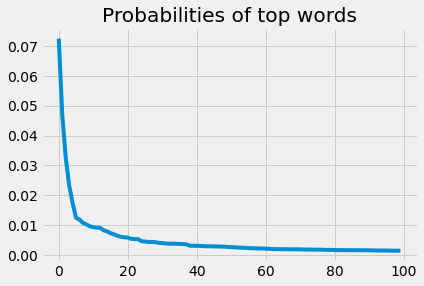

In [15]:
probs = next_word_logits.softmax(0).detach().numpy()
sorted_word_probs = sorted(probs, reverse=True)
plt.plot(sorted_word_probs[:100])
plt.title('Probabilities of top words');

In [24]:
dict(most_probable(next_word_logits, k=1000000))['</s>']

5.92139e-07

In [25]:
tokenizer.tokenize('<pad>')

[0]

In [26]:
tokenizer.decode(0), tokenizer.decode(1)

('<pad>', '<unk>')

I just realized, that in my vocab I forgot to put \<pad\> and \<unk\> tokens! This means that my models might not work properly, and this can be the reason for poor performance of my style transfer experiments.

EDIT: solved now

In [28]:
random.seed(42)
def generate_random_sequence_from(words):
    tokens = [tokenizer.tokenize(word)[0] for word in words]
    while words[-1] != '.' and words[-1] != '<pad>':
        x = torch.tensor([tokens])
        x_len = [len(tokens)]
        next_word_logits = model.decode(x, x_len)[0, -1, :]
        predicted_token = random.choices(np.arange(len(next_word_logits)), weights=next_word_logits.softmax(0))[0]
        tokens.append(predicted_token)
        words.append(tokenizer.decode(predicted_token))
    return ' '.join(words)
for _ in range(30):
    print(generate_random_sequence_from(["The"]))

The pizza ! </s> </s> .
The price was also mediocre .
The delivery i 'm done .
The new dream dog pizza ! </s> </s> .
The chairs were filthy .
The best service i have ever had in my life .
The people were really nice ! </s> </s> ! </s> </s> .
The pizza and i ca n't wait to move .
The ribs .
The french toast is incredible .
The spring rolls .
The atmosphere .
The exceptionally dim sum options .
The place constantly staffed .
The errors .
The noise and prices were great .
The yard has a beer .
The philadelphia rolls .
The best donut you ever used at ! </s> </s> .
The events here , great latte legs .
The entrees are basically too soggy .
The pizza is amazing .
The music said it ! </s> </s> .
The stuff they do ! </s> .
The best happy hour on the east side .
The espresso tea cake .
The music my energy actually working at it .
The bowl .
The food is beef .
The best mexican food ive had .


Interesting fact: when you use a token that never occurs, the RNN can predict it as a possible output. In fact it does it quite often. When unknown token is put into the model, the model doesn't know what to do, the logits can become big since the embedding of the unknown token wasn't optimized at all.

I have to solve it now.